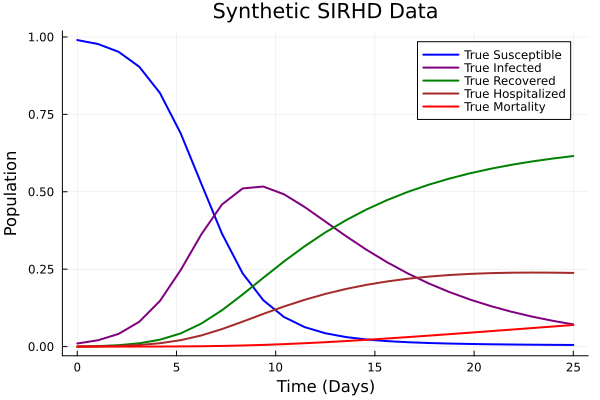

In [81]:
#Load required packages
using DifferentialEquations, Random, ModelingToolkit
using Lux, ComponentArrays
using Optimization, OptimizationOptimJL, DiffEqFlux
import Plots  

N_days = 25    #number of days
S0 = 1.0       # Total population (normalized to 1.0)
u0 =u0 = [S0*0.99, S0*0.01, 0.0, 0.0, 0.0] #[S0*0.99, S0*0.01, 0.00, 0.00, 0.00] #initial conditions

#transmision rate, infection rate, hospitalized rate and mortality rate
p0 = [0.85, 0.1, 0.05, 0.02] 
tspan = (0.0, Float64(N_days))  #Time range for simulation
t = range(tspan[1], tspan[2], length = N_days) #Time points for evaluation

# Define the classical SIRHD model as an ODE
function SIRHD!(du, u, p, t)
    (S, I, R, H, D) = u
    (β , γ, δ, η) = abs.(p)  #Ensure parameters are non negative
    du[1] = -β * S * I
    du[2] = β * S * I - γ * I - δ * I
    du[3] = γ * I
    du[4] = δ * I - η * H
    du[5] = η * H
end

#Solve the ODE to generate synthetic data

prob = ODEProblem(SIRHD!, u0, tspan, p0)
true_sol = solve(prob, Tsit5(), saveat=t)
S_true = [u[1] for u in true_sol.u]
I_true = [u[2] for u in true_sol.u]
R_true = [u[3] for u in true_sol.u]
H_true = [u[4] for u in true_sol.u]
M_true = [u[5] for u in true_sol.u]

tvals = true_sol.t

# Plot the synthetic generated data
plot(tvals, S_true, lw=2, xlabel="Time (Days)", ylabel="Population", label="True Susceptible", title="Synthetic SIRHD Data", color=:blue)
plot!(tvals, I_true, lw=2, label = "True Infected", color=:purple)
plot!(tvals, R_true, lw =2, label = "True Recovered", color=:green)
plot!(tvals, H_true , lw=2, label="True Hospitalized", color=:brown)
plot!(tvals, M_true, lw=2, label="True Mortality", color=:red)



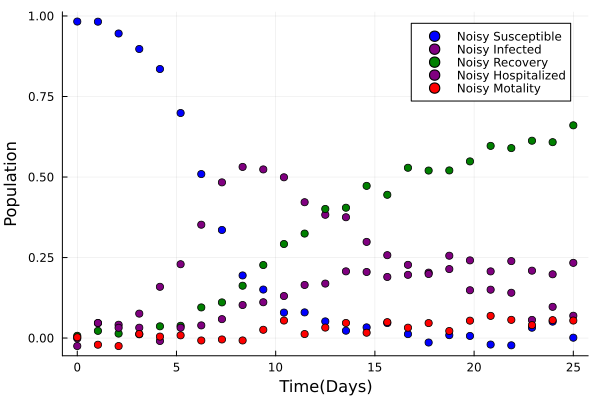

In [80]:
# Add noise to the syntetic SIRHD data 

using Random
Random.seed!(42)
noise_level = 0.02

S_noisy = true_sol[1,:] .+ noise_level .* randn(length(S_true))
I_noisy = true_sol[2,:] .+ noise_level .* randn(length(I_true))
R_noisy = true_sol[3,:] .+ noise_level .* randn(length(R_true))
H_noisy = true_sol[4,:] .+ noise_level .* randn(length(H_true))
M_noisy = true_sol[5,:] .+ noise_level .* randn(length(M_true))

#Plot the noisy data
Plots.plot(
    tvals, S_noisy, xlabel="Time(Days)",
    ylabel="Population", label="Noisy Susceptible", seriestype=:scatter, color=:blue
)
Plots.scatter!(tvals, I_noisy, label="Noisy Infected", color=:purple)
Plots.scatter!(tvals, R_noisy, label= "Noisy Recovery", color=:green)
Plots.scatter!(tvals, H_noisy, label = "Noisy Hospitalized", color=:purple)
Plots.scatter!(tvals, M_noisy,label = "Noisy Motality", color=:red)
    
    




In [63]:
#Construct the UDE Model (Neural Network Driven SIRHD Model)
Random.seed!(42)
rng = Random.default_rng()
NN_SI = Lux.Chain(Lux.Dense(2, 10, relu), Lux.Dense(10, 1)) # Neural Network for transmission rate(β)
NN_IR = Lux.Chain(Lux.Dense(1, 10, relu), Lux.Dense(10, 1)) # Neural Network for recovery rate(γ)

#Initialize Neural Network Parameters
p1, st1 = Lux.setup(rng, NN_SI)
p2, st2 = Lux.setup(rng, NN_IR)

#Store all Neural Network in a structure format
p0_vec = (layer_1 = p1, layer_2 = p2)
p0_vec = ComponentArray(p0_vec)  #Convert to Component Array for Optimization

# Define a softpluc activation function to ensure non negative outputs
function my_softplus(x)
    return log(1 + exp(x))
end







my_softplus (generic function with 1 method)

In [64]:
#Define the SIRHD Universal Differential Equation Model (UDE)
function ude_SIRHD!(du, u, p, t)
    (S, I, R, H, D) = u

    #Compute parameters for using Neural Network
    NNSI, _ = NN_SI([S, I],p.layer_1, st1) # Predict τNNSI using NN_SI
    NNIR, _ = NN_IR([I], p.layer_2, st2)   # Predict τNNIR using NN_IR

    τNNSI = clamp(my_softplus(NNSI[1]), 1e-05, 1) # Clamp τNNSI between min and max
    τNNIR = clamp(my_softplus(NNIR[1]), 1e-04, 1) # Clamp τNNIR between min and max
    δ = 0.05
    η = 0.02

    # Define the UDE dynamics
    du[1] = -τNNSI * S * I
    du[2] = τNNSI * S * I - τNNIR * I - δ * I
    du[3] = τNNIR * I
    du[4] = δ * I - η  * H
    du[5] = η * H
end

ude_prob = ODEProblem(ude_SIRHD!, u0, tspan, p0_vec)  # Define the UDE problem
            
        
        

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
Non-trivial mass matrix: false
timespan: (0.0, 25.0)
u0: 5-element Vector{Float64}:
 0.99
 0.01
 0.0
 0.0
 0.0

In [65]:
# Define Loss Function 
function loss_function(p)
    sol = solve(ude_prob, Tsit5(), u0=u0, p=p, sensealg=QuadratureAdjoint(), saveat=tvals)

    if any(x-> any(isnan, x), sol.u) || length(sol.u) != length(sol.t)
        return Inf
    end
    return sum(abs2, sol[2,:] .- I_noisy) #Mean square error on the Infected(I) case
end

loss_function (generic function with 1 method)

In [66]:
# Training the Model using LBFGS Optimizer

opt_func = OptimizationFunction((x,p) -> loss_function(x), Optimization.AutoZygote())
opt_prob = OptimizationProblem(opt_func, p0_vec)

train_params = solve(opt_prob, OptimizationOptimJL.LBFGS(); maxiters=200)

#Solve with Trained Parameter

trained_sol = solve(ude_prob, Tsit5(), p=train_params.u, saveat=tvals)

retcode: Success
Interpolation: 1st order linear
t: 25-element Vector{Float64}:
  0.0
  1.0416666666666667
  2.0833333333333335
  3.125
  4.166666666666667
  5.208333333333333
  6.25
  7.291666666666667
  8.333333333333334
  9.375
 10.416666666666666
 11.458333333333334
 12.5
 13.541666666666666
 14.583333333333334
 15.625
 16.666666666666668
 17.708333333333332
 18.75
 19.791666666666668
 20.833333333333332
 21.875
 22.916666666666668
 23.958333333333332
 25.0
u: 25-element Vector{Vector{Float64}}:
 [0.99, 0.01, 0.0, 0.0, 0.0]
 [0.9767416424281817, 0.020974857441554518, 0.0015106148806880932, 0.0007658646534973479, 7.020596078335882e-6]
 [0.9502027546612162, 0.042809495739932715, 0.004615922286916741, 0.0023344184936378285, 3.7408818296527095e-5]
 [0.9007308913600746, 0.08300154505217988, 0.01071636653586121, 0.00543635455897482, 0.00011484249290951848]
 [0.8190360136164664, 0.147711167215108, 0.021803421669507654, 0.011167250538222265, 0.00028214696069565627]
 [0.7032035599776628, 0.

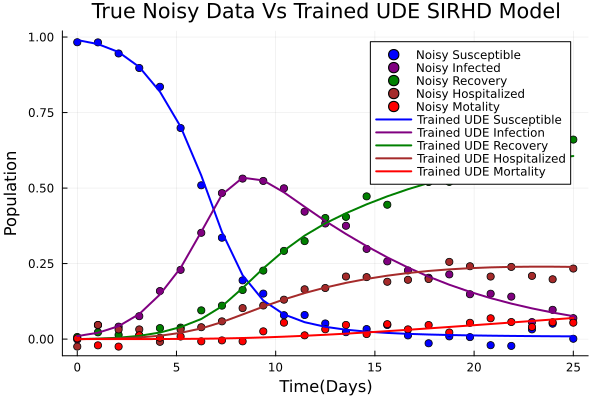

In [83]:
# Compare the True Noisy Synthetic Data with Trained UDE SIRHD Model

Plots.plot(
    tvals, S_noisy, xlabel="Time(Days)",
    ylabel="Population", label="Noisy Susceptible", seriestype=:scatter, color=:blue
)
Plots.scatter!(tvals, I_noisy, label="Noisy Infected", color=:purple)
Plots.scatter!(tvals, R_noisy, label= "Noisy Recovery", color=:green)
Plots.scatter!(tvals, H_noisy, label = "Noisy Hospitalized", color=:brown)
Plots.scatter!(tvals, M_noisy,label = "Noisy Motality", color=:red, title= "True Noisy Data Vs Trained UDE SIRHD Model")

Plots.plot!(tvals, trained_sol[1,:], lw=2, label="Trained UDE Susceptible", color=:blue)
Plots.plot!(tvals,  trained_sol[2,:], lw=2, label= "Trained UDE Infection", color=:purple)
Plots.plot!(tvals,  trained_sol[3,:], lw = 2, label= "Trained UDE Recovery", color=:green)
Plots.plot!(tvals,  trained_sol[4, :], lw=2, label = "Trained UDE Hospitalized", color=:brown)
Plots.plot!(tvals, trained_sol[5,:], lw=2 , label = "Trained UDE Mortality", color=:red)

In [53]:
#Extrapolation

N_days2 = 50  # Duration of the simulation (in days)

tspan2 = (0.0, Float64(N_days2))  # Time range for simulation
t2 = range(tspan2[1], tspan2[2], length=N_days2)  # Time points for evaluation

ude_prob2 = ODEProblem(ude_SIRHD!, u0, tspan2, p0_vec)
trained_sol2 = solve(ude_prob2, Tsit5(), p=train_params.u, saveat=t2)


retcode: Success
Interpolation: 1st order linear
t: 50-element Vector{Float64}:
  0.0
  1.0204081632653061
  2.0408163265306123
  3.061224489795918
  4.081632653061225
  5.1020408163265305
  6.122448979591836
  7.142857142857143
  8.16326530612245
  9.183673469387756
 10.204081632653061
 11.224489795918368
 12.244897959183673
  ⋮
 38.775510204081634
 39.795918367346935
 40.816326530612244
 41.83673469387755
 42.857142857142854
 43.87755102040816
 44.89795918367347
 45.91836734693877
 46.93877551020408
 47.95918367346939
 48.97959183673469
 50.0
u: 50-element Vector{Vector{Float64}}:
 [0.99, 0.01, 0.0, 0.0, 0.0]
 [0.9787038974817808, 0.018477039963429507, 0.0021146281467957135, 0.0006980186309094363, 6.415777084676159e-6]
 [0.957998068919151, 0.03415865104799294, 0.0058368723401916395, 0.0019740343921096784, 3.237330055483093e-5]
 [0.9203094188784365, 0.06315326342459551, 0.012123620435239037, 0.004319523728291752, 9.417353343718801e-5]
 [0.8527918406848392, 0.11640658402300293, 0.02194

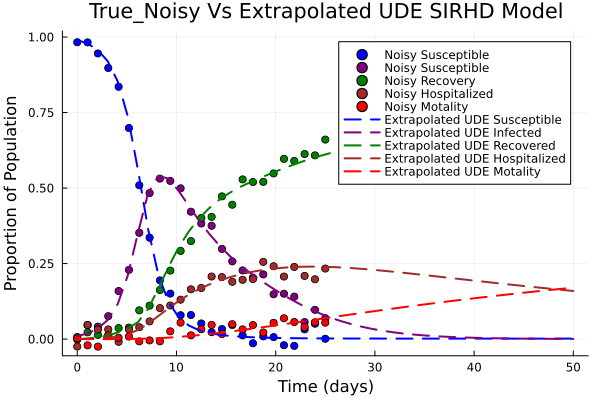

In [82]:
# Compare Noisy Synthetic Data with Extrapolated UDE Model
Plots.plot(
    tvals, S_noisy, xlabel="Time(Days)",
    ylabel="Population", label="Noisy Susceptible", seriestype=:scatter, color=:blue
)
Plots.scatter!(tvals, I_noisy, label="Noisy Susceptible", color=:purple)
Plots.scatter!(tvals, R_noisy, label= "Noisy Recovery", color=:green)
Plots.scatter!(tvals, H_noisy, label = "Noisy Hospitalized", color=:brown)
Plots.scatter!(tvals, M_noisy,label = "Noisy Motality", color=:red)

plot!(t2, trained_sol2[1, :], label="Extrapolated UDE Susceptible", linewidth=2, linestyle=:dash, color=:blue)
plot!(t2, trained_sol2[2, :], label="Extrapolated UDE Infected", linewidth=2, linestyle=:dash, color=:purple)
plot!(t2, trained_sol2[3, :], label="Extrapolated UDE Recovered", linewidth=2, linestyle=:dash, color=:green)
plot!(t2, trained_sol2[4, :], label= "Extrapolated UDE Hospitalized", lw=2, linestyle=:dash , color=:brown)
plot!(t2, trained_sol2[5,:], label="Extrapolated UDE Motality", lw=2, linestyle=:dash, color =:red)

xlabel!("Time (days)")
ylabel!("Proportion of Population")
title!("True_Noisy Vs Extrapolated UDE SIRHD Model")

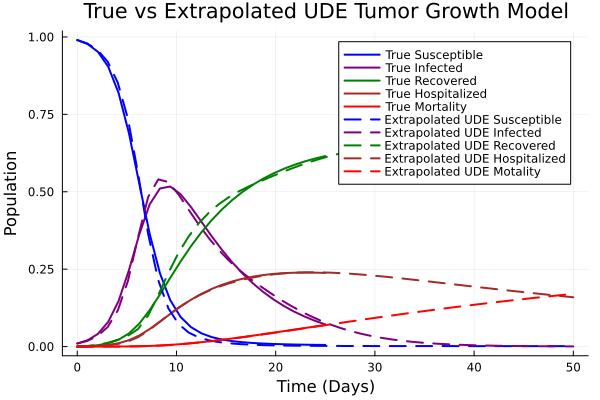

In [77]:
# Compare True non-Noisy Synthetic Data with Extrapolated Trained UDE Model

plot(tvals, S_true, lw=2, xlabel="Time (Days)", ylabel="Population", label="True Susceptible", color=:blue)
plot!(tvals, I_true, lw=2, label = "True Infected", color=:purple)
plot!(tvals, R_true, lw =2, label = "True Recovered", color=:green)
plot!(tvals, H_true , lw=2, label="True Hospitalized", color=:brown)
plot!(tvals, M_true, lw=2, label="True Mortality", color=:red)

plot!(t2, trained_sol2[1, :], label="Extrapolated UDE Susceptible", linewidth=2, linestyle=:dash, color=:blue)
plot!(t2, trained_sol2[2, :], label="Extrapolated UDE Infected", linewidth=2, linestyle=:dash, color=:purple)
plot!(t2, trained_sol2[3, :], label="Extrapolated UDE Recovered", linewidth=2, linestyle=:dash, color=:green)
plot!(t2, trained_sol2[4, :], label= "Extrapolated UDE Hospitalized", lw=2, linestyle=:dash , color=:brown)
plot!(t2, trained_sol2[5,:], label="Extrapolated UDE Motality", lw=2, linestyle=:dash, color =:red)
title!("True vs Extrapolated UDE Tumor Growth Model")
